## Importing libraries and reading data

In [1]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Scikit-learn

# RDKit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

In [2]:
HERE = Path(_dh[-1])
DATA_PATH = HERE.parent.parent.parent/'data/fda_approved_datasets'

# Importing all fda approved drugs
fda_drugs_without_desc = pd.read_csv(DATA_PATH/'fda_approved_drugs.csv')
fda_drugs_without_desc

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,False,True,False,False
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,False,True,False,False
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,False,True,False,False
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,False,True,False,True
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,BLEOMYCIN,CHEMBL403664,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1973,BLEOMYCIN SULFATE,Small molecule,False,True,False,False,True,False,True,False
1891,VANCOMYCIN,CHEMBL262777,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1964,VANCOMYCIN HYDROCHLORIDE,Small molecule,False,True,False,False,True,True,True,False
1892,COLISTIMETHATE SODIUM,CHEMBL1201441,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1970.0,Antibacterial,Small molecule,False,True,False,False,True,False,True,False
1893,TELAVANCIN,CHEMBL507870,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,TELAVANCIN HYDROCHLORIDE,Small molecule,False,True,False,False,True,False,True,False


## Calculating 'rule-based' descriptors

We will compute a range of descriptors based on well-known rules, including but not limited to '*Lipinski's Rule of Five*' and '*Veber's Rules*.' These descriptors will be used to generate plots, enabling an exploration of the relationships between these variables.

In [3]:
rule_based_descriptors =  [
'exactmw',
'fractioncsp3',
'numaliphaticheterocycles',
'numaliphaticrings',
'numamidebonds',
'numaromaticheterocycles',
'numaromaticrings',
'numatomstereocenters',
'numatoms',
'numbridgeheadatoms',
'numhba',
'numhbd',
'numheavyatoms',
'numheteroatoms',
'numheterocycles',
'lipinskihba',
'lipinskihbd',
'numrings',
'numrotatablebonds',
'numsaturatedrings',
'tpsa',
'crippenclogp'
]

With the `rdMolDescriptors` module, you can calculate a variety of molecular properties, commonly referred to as "descriptors," using the `rdMolDescriptors.Properties(list)` object. When you provide a `list` of specific descriptor names, it will compute only those descriptors that are included in the list. First step is to check if those properties on the list above are written correctly and we do that doing a list comprehension.

In [4]:
available_descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

# Checking the correct name of descriptors
rule_based_descriptor_names = [desc for desc in available_descriptor_names if desc.lower() in rule_based_descriptors]

rule_based_descriptors = rule_based_descriptor_names

Finally, we can define a function to compute the chosen descriptors and for all the FDA approved drugs for each given SMILES structure. The function is defined below:

In [5]:
def compute_rule_based_descriptors(smiles:str, descriptors_list:str) -> dict:
    """
    Function to compute rule-based/heuristic descriptors from a given list of descriptors name
    
    smiles: curated SMILES list
    descriptors_list: names of descriptors to calculate (must be correct names of rdMolDescriptors.Properties.GetAvailableProperties)    
    """

    descriptor_calculator = rdMolDescriptors.Properties(descriptors_list)

    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError("The conversion resulte do NoneType! Check SMILES")
    except Exception as err:
        return print(f'The structure {smiles} cannot be converted! {err}')
    
    descriptors_dict = {"smiles": smiles}
    for descriptor_name, descriptor_value in zip(descriptor_calculator.GetPropertyNames(), descriptor_calculator.ComputeProperties(mol)):
        descriptors_dict[descriptor_name] = descriptor_value
    
    return descriptors_dict


In [6]:
# Input list for SMILES
smiles_list = fda_drugs_without_desc['clean_smiles'].to_list()

# Compute heuristic descriptors
descriptors_result = []
for smiles in smiles_list:
    descriptors_result.append(compute_rule_based_descriptors(smiles, rule_based_descriptors))

# Generate dataframe from list of dicts
rule_based_descriptors_df = pd.DataFrame(descriptors_result)
rule_based_descriptors_df

,smiles,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,tpsa,CrippenClogP
0,N=C(N)N,59.048347,3.0,5.0,0.0,3.0,1.0,4.0,9.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.89,-1.16143
1,CC(=O)NO,75.032028,3.0,2.0,0.0,2.0,2.0,5.0,10.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.33,-0.48830
2,NC(=O)NO,76.027277,4.0,4.0,0.0,3.0,2.0,5.0,9.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.35,-0.95610
3,NCCS,77.029920,1.0,2.0,1.0,2.0,2.0,4.0,11.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.02,-0.12510
4,C[S+](C)[O-],78.013936,1.0,0.0,0.0,0.0,1.0,4.0,10.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.06,-0.00530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1414.518432,38.0,25.0,35.0,20.0,31.0,96.0,180.0,41.0,...,4.0,2.0,2.0,6.0,4.0,2.0,0.0,19.0,627.07,-7.70358
1891,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1447.430200,33.0,21.0,13.0,19.0,25.0,101.0,176.0,35.0,...,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,530.49,0.10620
1892,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1638.627902,44.0,23.0,44.0,23.0,28.0,107.0,217.0,49.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,13.0,692.56,-8.06040
1893,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,1753.637429,38.0,24.0,30.0,23.0,28.0,121.0,227.0,41.0,...,5.0,7.0,2.0,7.0,0.0,7.0,11.0,18.0,598.09,2.69220


### Checking missing values

It is always important to check if there is any missing value (NA) in the descriptor matrix as such values will be limitant to further analysis.

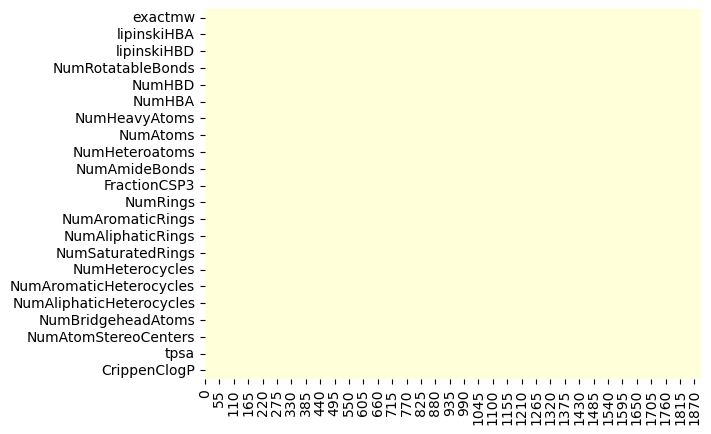

In [7]:
missing_na_heatmap = sns.heatmap(rule_based_descriptors_df.drop(columns=['smiles']).isna().transpose(), cmap='YlGnBu', cbar=False)

## Relationship plots

### Heatmap correlation plot

In [8]:
data_corr = rule_based_descriptors_df.drop(columns=['smiles']).corr()

Text(0.5, 120.24999999999996, '')

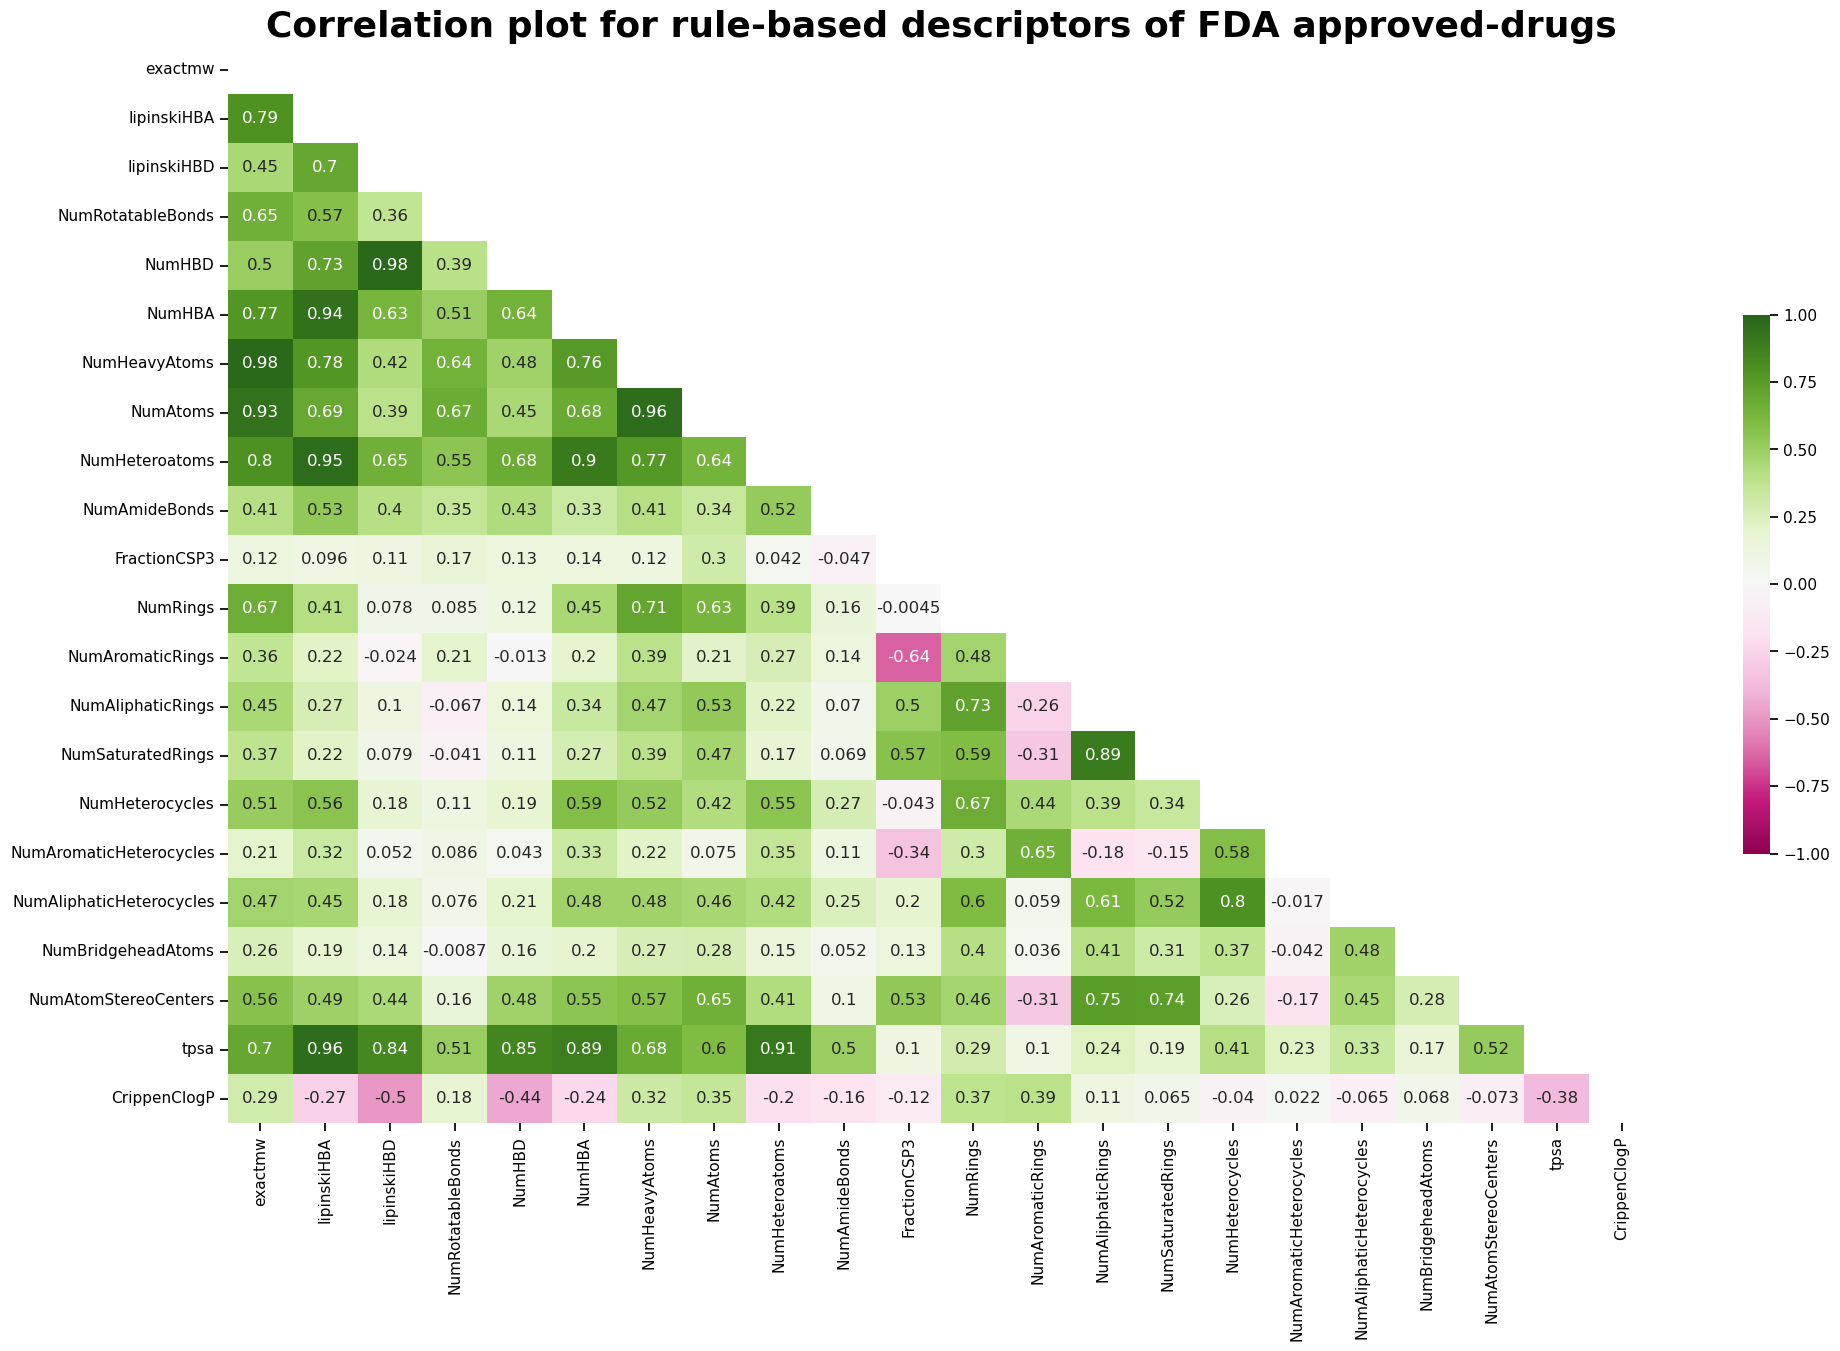

In [9]:
sns.set_context('notebook')
plt.figure(figsize=(23,14))
mask = np.triu(data_corr)
correlation_heatmap = sns.heatmap(data=data_corr, mask=mask, vmax=1, vmin=-1,annot=True, cmap='PiYG', cbar_kws={'shrink':0.5})
correlation_heatmap.set_title('Correlation plot for rule-based descriptors of FDA approved-drugs', fontsize= 26, fontdict={'weight':'bold'})
correlation_heatmap.set_ylabel(correlation_heatmap.get_ylabel(), fontdict={'weight':'bold'})
correlation_heatmap.set_xlabel(correlation_heatmap.get_xlabel(), fontdict={'weight':'bold'})
